<a href="https://colab.research.google.com/github/Tom-Lennox/Kaggle/blob/master/housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# title

In [1]:
# kaggle APIセット
!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
# 「Download 100%.」と表示で成功。

# [kaggle.json]を持参する。
from google.colab import drive
drive.mount('/content/drive')

# jsonファイルを指定の場所に配置
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

# リスト見たい場合
!kaggle datasets list

# train, test等ダウンロード
! kaggle competitions download house-prices-advanced-regression-techniques -p house-prices

# ダウンロードしたらここに入る大体。
!ls /content/house-prices

Download 100%.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, s

In [2]:
# jsonファイルを指定の場所に配置
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

# リスト見たい場合
# !kaggle datasets list

# train, test等ダウンロード
! kaggle competitions download house-prices-advanced-regression-techniques -p house-prices

# ダウンロードしたらここに入る大体。
!ls /content/house-prices

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.4MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 11.1MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 59.7MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.8MB/s]
data_description.txt  sample_submission.csv  test.csv  train.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# とりあえずファイルを読み込む
train = pd.read_csv("/content/house-prices/train.csv")
test = pd.read_csv("/content/house-prices/test.csv")
# 読み込んだら確認したい
# train.head()
# test.head()

# array形式で確認したい場合（省略）
# print(np.array(test))
# 省略したくない場合は下記
# print('---')
# np.set_printoptions(threshold=np.inf)
# print(np.array(test))
# train.head(3)

# ==
# 配列の大きさを確認したい。
train['WhatIsData'] = 'Train'
test['WhatIsData'] = 'Test'
test['SalePrice'] = 9999999999
alldata = pd.concat([train,test],axis=0).reset_index(drop=True)
print('The size of train is : ' + str(train.shape))
print('The size of test is : ' + str(test.shape))
# ==
# train.info()

#  ■ わかること
# データ数：1460
# [Age, Cabin, Embarked]にnullあり。
# データ型が色々あること
# ⇒ dtypes: float64(3), int64(35), object(44)
# ==
# ■欠損値の確認
# （１つ１つpickしていくのは面倒。）
# pd.get_option("display.max_rows") # 行数取得
# pd.get_option("display.max_colwidth") # 列数取得

# ＝＝
# ■作業中■
# ■表示省略させない
# 下記はx（何で？）
# pd.set_option("display.max_rows", 80)
# pd.get_option("display.max_colwidth", 80)
# 下記はo（何で？）
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
# ＝＝
pd.options.display.max_columns = None
# print(pd.options.display.max_columns)
np.set_printoptions(threshold=np.inf)
# train.isnull()
# train.isnull().sum()

# ＝＝
# ■1以上のカラム名だけ取得できる。
# iteritems()
l = []
for index, value in train.isnull().sum().iteritems():
    if value > 0:
        l.append(index)
l
# 以下、駄文
# ■null等は勝手に埋めない。カラムの意味をしっかり把握する。
# nullに意味ある場合もある（a.g.　設備の有無等）
# ｜FLGを01で表現するか、nullで表現するかは場合による。

# ['LotFrontage',
#  'Alley',
#  'MasVnrType',
#  'MasVnrArea',
#  'BsmtQual',
#  'BsmtCond',
#  'BsmtExposure',
#  'BsmtFinType1',
#  'BsmtFinType2',
#  'Electrical',
#  'FireplaceQu',
#  'GarageType',
#  'GarageYrBlt',
#  'GarageFinish',
#  'GarageQual',
#  'GarageCond',
#  'PoolQC',
#  'Fence',
#  'MiscFeature']

# ['LotFrontage,間口の広さ
#  'Alley',路地？
# Grvl    50  ？未舗装？
# Pave    41  舗装
#  'MasVnrType',？？の種類？柄か？壁？
# BrkCmn      15
# BrkFace    445
# None       864
# Stone      128
#  'MasVnrArea',？？の面積？庭？壁？壁か？
#  ⇒ 他の人の検索するとベニヤ板って書いてあるけど違うと思う。
# 0.0       861
# 1.0         2
# 11.0        1
# 14.0        1
# 16.0        7
#          ... 
# 1115.0      1
# 1129.0      1
# 1170.0      1
# 1378.0      1
# 1600.0      1
#  'BsmtQual',Bsmtの質？■Bsmtシリーズ。何これ？
#  ⇒ 評価っぽい。？劣化度合いとか？
# Ex    121
# Fa     35
# Gd    618
# TA    649
#  'BsmtCond',条件？condominium?
# 同上。
# Fa      45
# Gd      65
# Po       2
# TA    1311
#  'BsmtExposure',暴露?
#  ⇒ 向き！でもMnとかよくわからん。
# Av    221
# Gd    134
# Mn    114
# No    953
#  'BsmtFinType1',フィン？水かき？のタイプ
# QはQualityなのでは？
# ALQ    220
# BLQ    148
# GLQ    418
# LwQ     74
# Rec    133
# Unf    430
#  'BsmtFinType2',フィン？水かき？のタイプ2
#  ⇒ 「Unf」突然増えた。
# ALQ      19
# BLQ      33
# GLQ      14
# LwQ      46
# Rec      54
# Unf    1256
#  'Electrical',電気的？
# ヒューズ。契約か？
# FuseA      94
# FuseF      27
# FuseP       3
# Mix         1
# SBrkr    1334
#  'FireplaceQu',暖炉？
# Ex     24
# Fa     33
# Gd    380
# Po     20
# TA    313
#  'GarageType',ガレージ■ガレージ
# 2Types       6
# Attchd     870
# Basment     19
# BuiltIn     88
# CarPort      9
# Detchd     387
#  'GarageYrBlt',ガレージの？？
#  ⇒ 年っぽい。
# 1900.0     1
# 1906.0     1
# 1908.0     1
# 1910.0     3
# 1914.0     2
#           ..
# 2006.0    59
# 2007.0    49
# 2008.0    29
# 2009.0    21
# 2010.0     3
#  'GarageFinish',ガレージの仕上げ？
# Fin    352
# RFn    422
# Unf    605
#  'GarageQual',ガレージの質？
# Ex       3
# Fa      48
# Gd      14
# Po       3
# TA    1311
#  'GarageCond',ガレージのcondominium?
# Ex       2
# Fa      35
# Gd       9
# Po       7
# TA    1326
#  'PoolQC',プール？
# Ex    2
# Fa    2
# Gd    3
#  'Fence',フェンス？
# GdPrv     59
# GdWo      54
# MnPrv    157
# MnWw      11
#  'MiscFeature']その他の特徴
# Gar2     2
# Othr     2
# Shed    49
# TenC     1
# カラム単位のユニーク要素をカウント。
# sort_index()つけるとorder byできる。

# ！rowが多いから減らした。
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

train['LotShape'].value_counts().sort_index()
# ＝＝
# ■カラムと欠損値の内容を調べた。
# 次に
# 欠損値を埋める？
# 使う変数を選ぶ？


The size of train is : (1460, 82)
The size of test is : (1459, 82)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



IR1    484
IR2     41
IR3     10
Reg    925
Name: LotShape, dtype: int64

In [4]:
# Street
# train.head(10)

# train.isnull().sum()
# train.dropna().shape

# 1460行
# Grvl    50
# Pave    41
# その他が 1460 - (50 + 41)
# train['Alley']
# train['Alley'].value_counts().sort_index()
# # ■NG;
# # 01に置き換える前に欠損値補填なんかできるわけない。
# train['Alley'] = train['Alley'].fillna(train['Alley'].medinan())

# train['Alley'][train['Alley'] == "Grvl"] = 0
train["Alley"][train["Alley"] == "Grvl"] = 0
# ■NG;
# intとstrだとカウントしてくれない。
# .sort_index()　を外せばok
# TypeError: '<' not supported between instances of 'str' and 'int'
train['Alley'].value_counts()
# 0       50
# Pave    41
# Grvlを0に。 ⇒ Paveを1に。
train["Alley"][train["Alley"] == "Pave"] = 1
train['Alley'].value_counts()
# 0    50
# 1    41
# ■dl
# 試しにmean()を入れてみる。
train['Alley'] = train['Alley'].fillna(train['Alley'].mean())
train['Alley'].value_counts()
# 0.450549    1369
# 0.000000      50
# 1.000000      41
# 01の評価に小数点以下は馬鹿っぽい。
# 下記にしたい。
# 舗装：1、砂利：2、路地ないよ：0
# リトライ
train = pd.read_csv("/content/house-prices/train.csv")
train["Alley"][train["Alley"] == "Grvl"] = 1
train["Alley"][train["Alley"] == "Pave"] = 2
train['Alley'] = train['Alley'].fillna(0)
train['Alley'].value_counts()

# ■重要そうな特徴量はどれ？

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/l

0    1369
1      50
2      41
Name: Alley, dtype: int64

In [5]:
train.head(10)

# # カラム、リストに。
# train.columns  # カラム名一括請求
# Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
#        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
#        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
#        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
#        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
#        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
#        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
#        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
#        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
#        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
#        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
#        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
#        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
#        'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
#        'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
#        'SaleCondition', 'SalePrice'],
#       dtype='object')

# MSSubClass
# LotFrontage
# LotArea
# Alley
# OverallQual
# YearBuilt
# YearRemodAdd
# MasVnrArea
# ExterQual
# BsmtQual
# 1stFlrSF
# 2ndFlrSF
# KitchenQual
# Fireplaces
# GarageType
# GarageArea
# GarageQual
# PoolArea
# SaleCondition
# SalePrice
# カラム内、一意
train['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

In [6]:
# train.head(10)

train.index    # index取得

# カラム、リストに。
train.columns  # カラム名一括請求

# pd.Series(train, name='MSSubClass').unique()

# 存在する要素をリストに
# 「目視確認」は馬鹿
train['Utilities'].value_counts()

# 型のみ
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley              int64
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [7]:
train.head(3)

# ■わかること
# 特徴量
# Name, Ticketはめんどくさそう

#  ■ やること
# 欠損値を埋める
# [Sex, Embarked]　intに変える
# ｜平均値でいいかな


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


歪度: 1.882876
尖度: 6.536282


Text(0, 0.5, 'SalePrice')

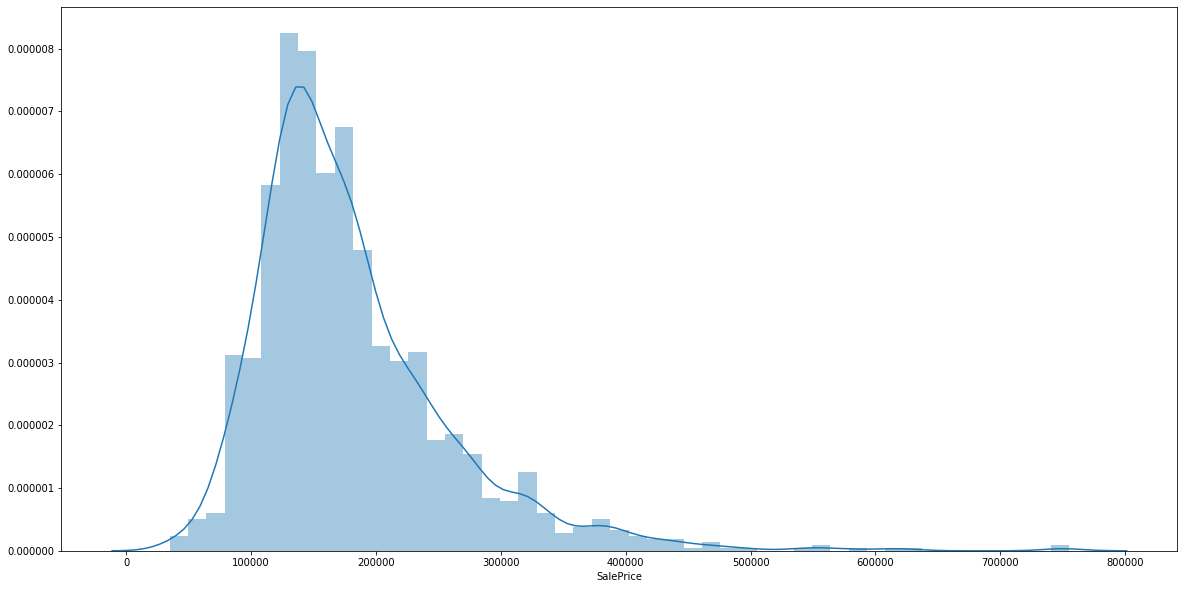

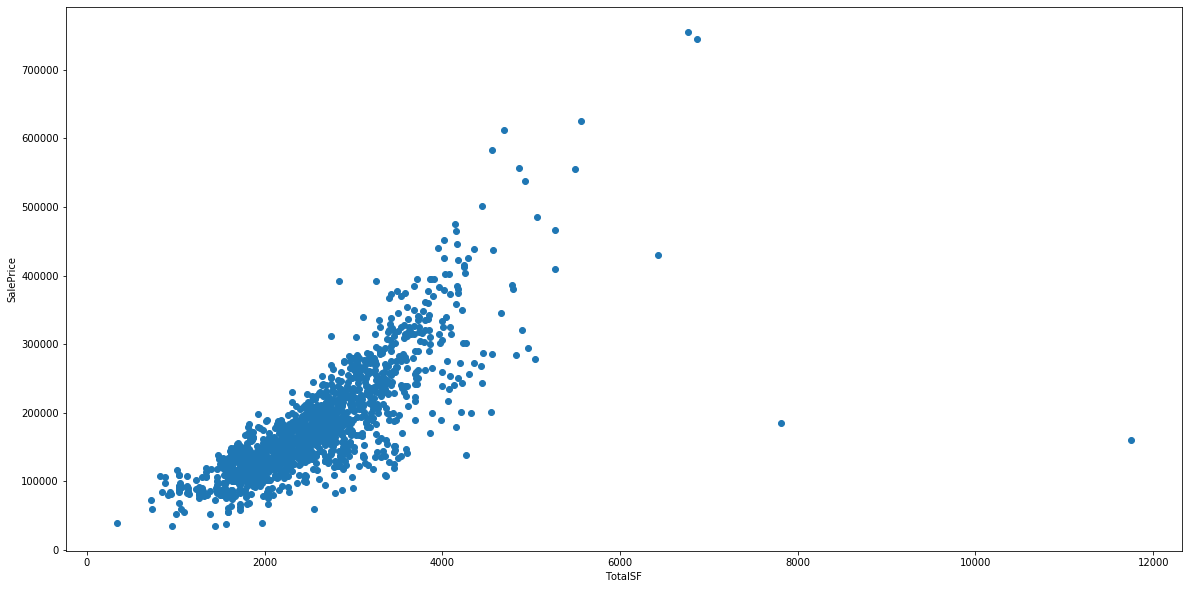

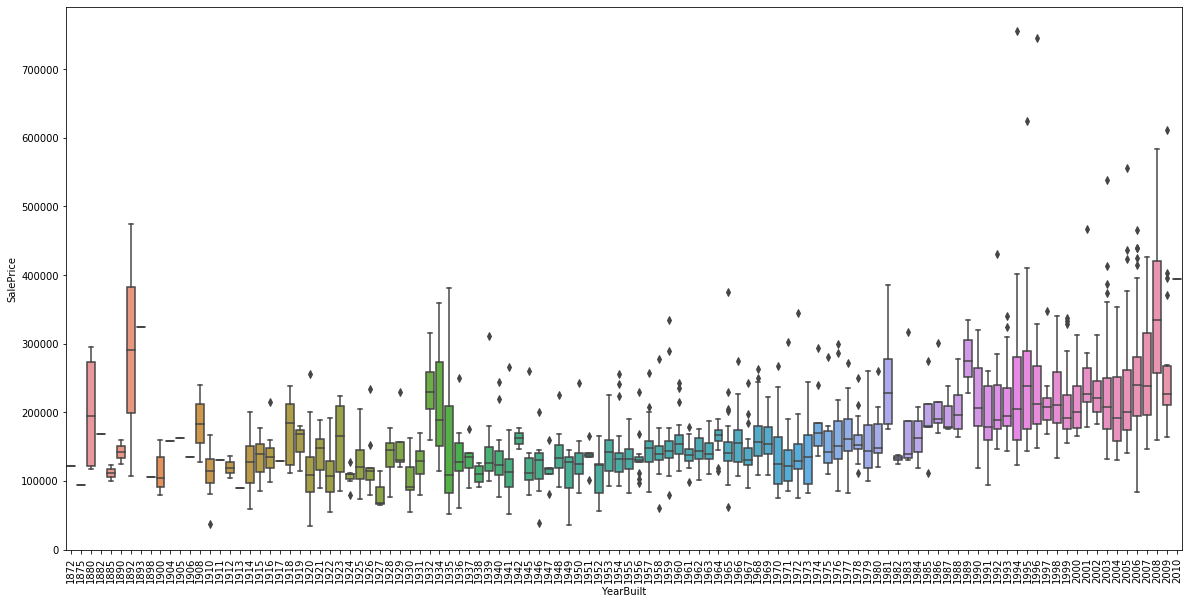

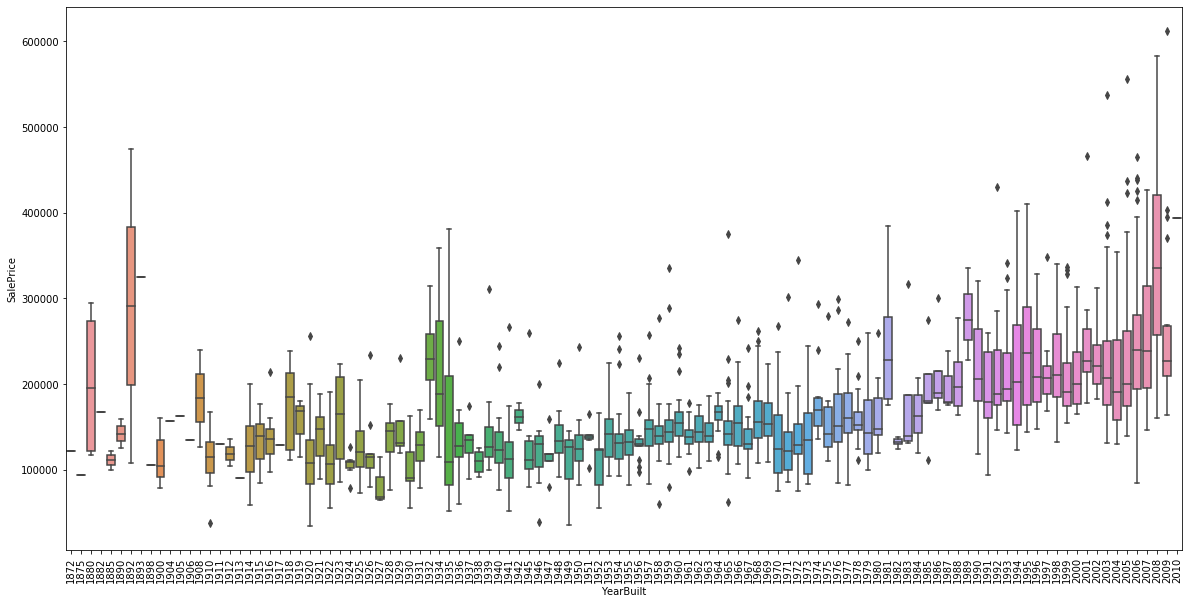

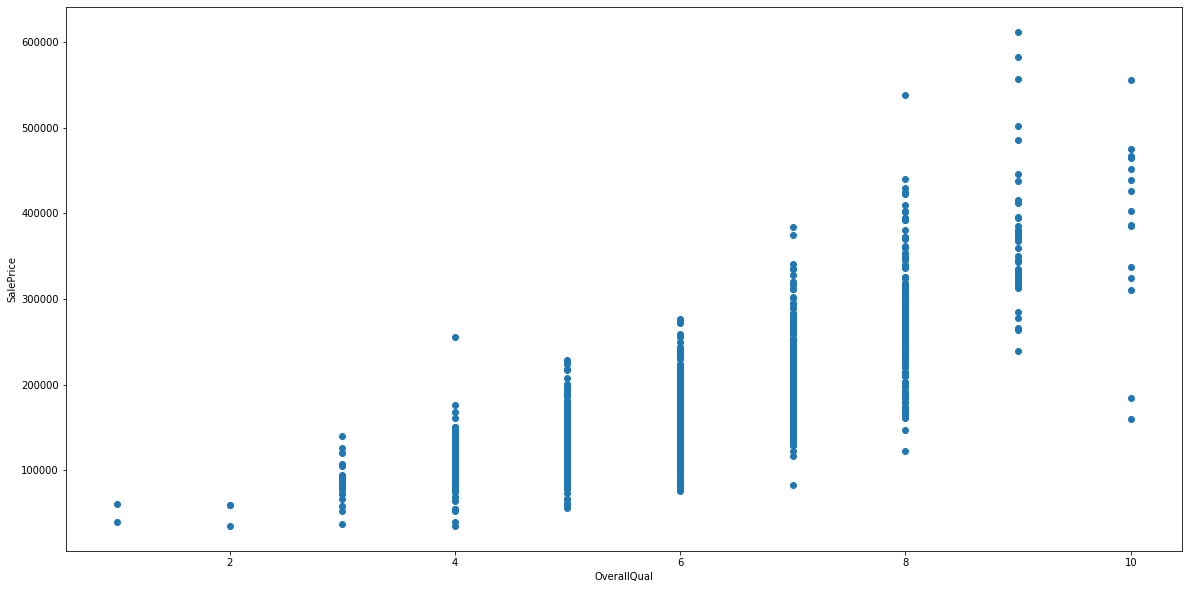

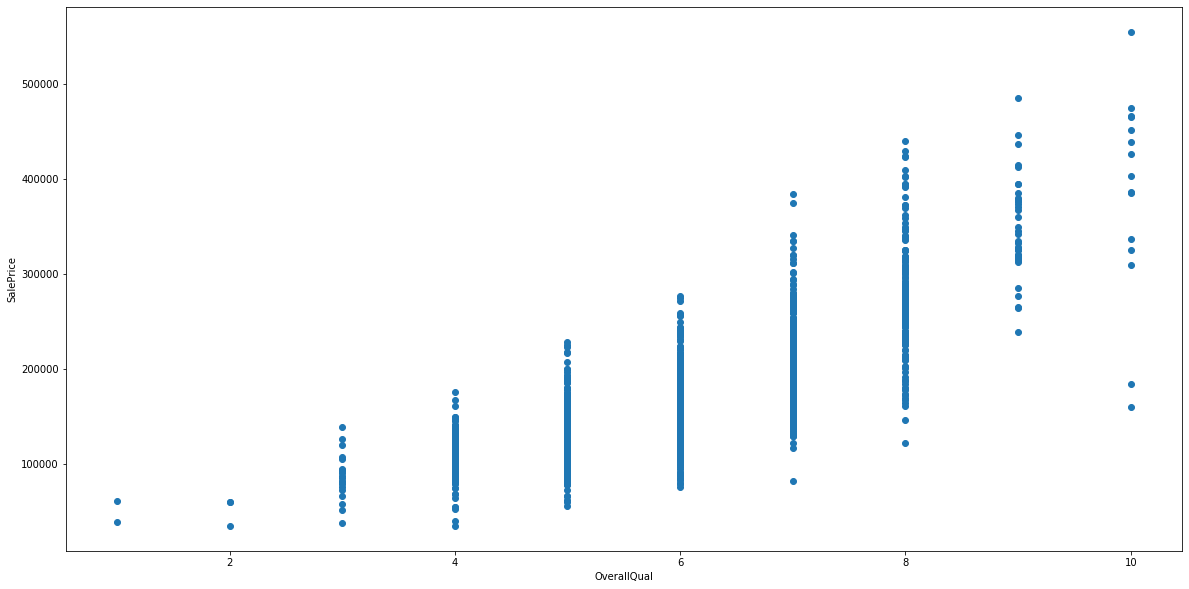

In [8]:
# ■手順
# 1_
#目的変数である家の価格の要約統計量を表示する
train["SalePrice"].describe()
# --
# mean
# count      1460.000000
# mean     180921.195890
# std       79442.502883
# min       34900.000000
# 25%      129975.000000
# 50%      163000.000000
# 75%      214000.000000
# max      755000.000000
# Name: SalePrice, dtype: float64
# --
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

#家の価格（目的変数）、ヒストグラム
plt.figure(figsize=(20, 10))
sns.distplot(train['SalePrice'])

#歪度と尖度を計算
print("歪度: %f" % train['SalePrice'].skew())
print("尖度: %f" % train['SalePrice'].kurt())


test_x = pd.read_csv("/content/house-prices/test.csv")

#物件の広さを合計した変数を作成
train["TotalSF"] = train["1stFlrSF"] + train["2ndFlrSF"] + train["TotalBsmtSF"]
test_x["TotalSF"] = test_x["1stFlrSF"] + test_x["2ndFlrSF"] + test_x["TotalBsmtSF"]

#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(20, 10))# x:広さ, y:金額　で表現
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")
# 広い方が高い（当然）

# ---------------------------------
#築年数と物件価格の散布図を作成
#plt.scatter(train["YearBuilt"],train["SalePrice"],color = "#e41a1c")
#plt.xlabel("YearBuilt")
#plt.ylabel("SalePrice")

data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)
# 新しい方が高い（当然？）
# 外れ値 = ◆

# ↓

#外れ値を除外する
# ？（こんなアナログな方法で良いのか？）
# 外れ値と言えるのか？
train = train.drop(train[(train['YearBuilt']<2000) & (train['SalePrice']>600000)].index)

#グラフを描画する
data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)
# ---------------------------------
# ---------------------------------
#家の材質・完成度と物件価格の散布図を作成
plt.figure(figsize=(20, 10))
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

# ↓

#外れ値を除外する
train = train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)
train = train.drop(train[(train['OverallQual']<10) & (train['SalePrice']>500000)].index)

#グラフを描画する
plt.figure(figsize=(20, 10))
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")
# ---------------------------------

train_x: (1451, 81)
train_y: (1451,)
test_x: (1459, 81)
all_data: (2910, 80)


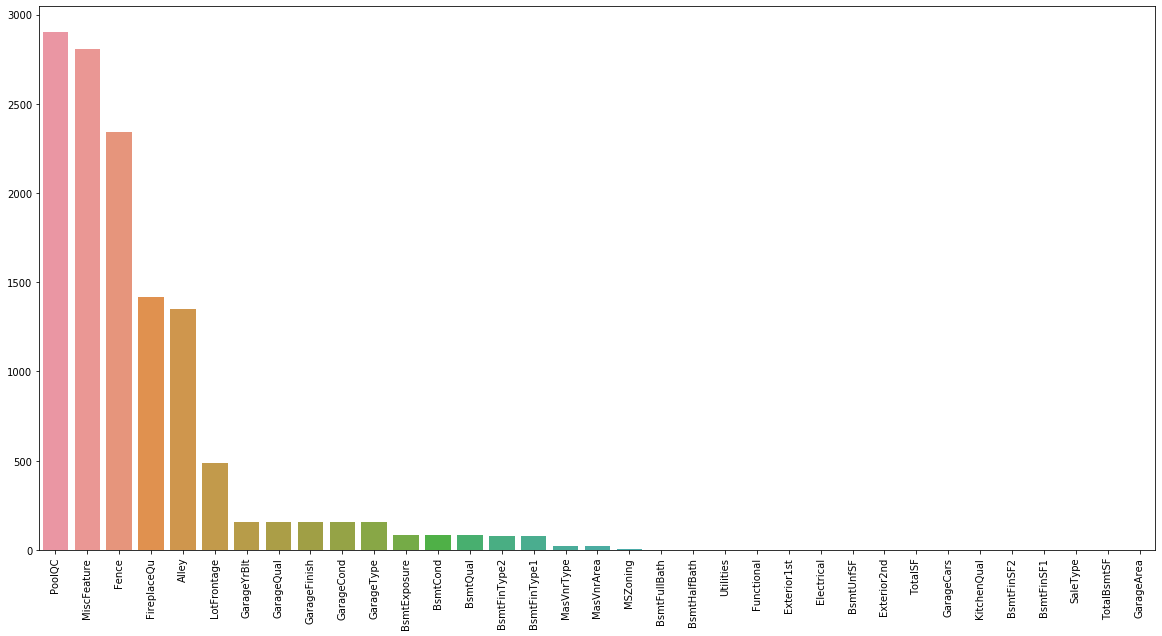

In [12]:
#学習データを目的変数とそれ以外に分ける
train_x = train.drop("SalePrice",axis=1)
train_y = train["SalePrice"]

#学習データとテストデータを統合
all_data = pd.concat([train_x,test_x],axis=0,sort=True)

#IDのカラムは不必要なので別の変数に格納
train_ID = train['Id']
test_ID = test_x['Id']

all_data.drop("Id", axis = 1, inplace = True)

#それぞれのデータのサイズを確認
print("train_x: "+str(train_x.shape))
print("train_y: "+str(train_y.shape))
print("test_x: "+str(test_x.shape))
print("all_data: "+str(all_data.shape))

#データの欠損値を確認する
all_data_na = all_data.isnull().sum()[all_data.isnull().sum()>0].sort_values(ascending=False)
all_data_na

#欠損値の数をグラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)

# 欠損値があるカラムをリスト化
na_col_list = all_data.isnull().sum()[all_data.isnull().sum()>0].index.tolist()

#欠損があるカラムのデータ型を確認
all_data[na_col_list].dtypes.sort_values()

In [13]:
# 欠損値があるカラムをリスト化
na_col_list = all_data.isnull().sum()[all_data.isnull().sum()>0].index.tolist()

#欠損があるカラムのデータ型を確認
all_data[na_col_list].dtypes.sort_values()

GarageArea      float64
TotalBsmtSF     float64
TotalSF         float64
BsmtFinSF1      float64
BsmtFinSF2      float64
GarageYrBlt     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
BsmtUnfSF       float64
MasVnrArea      float64
LotFrontage     float64
GarageType       object
KitchenQual      object
MasVnrType       object
MiscFeature      object
PoolQC           object
SaleType         object
MSZoning         object
GarageQual       object
Alley            object
GarageCond       object
Functional       object
FireplaceQu      object
Fence            object
Exterior2nd      object
Exterior1st      object
Electrical       object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
GarageFinish     object
Utilities        object
dtype: object

In [14]:
#隣接した道路の長さ（LotFrontage）の欠損値の補完
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#欠損値が存在するかつfloat型のリストを作成
float_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "float64"].index.tolist()

#欠損値が存在するかつobject型のリストを作成
obj_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "object"].index.tolist()

#float型の場合は欠損値を0で置換
all_data[float_list] = all_data[float_list].fillna(0)

#object型の場合は欠損値を"None"で置換
all_data[obj_list] = all_data[obj_list].fillna("None")

#欠損値が全て置換できているか確認
all_data.isnull().sum()[all_data.isnull().sum() > 0]

Series([], dtype: int64)

In [0]:
# カテゴリ変数に変換する
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

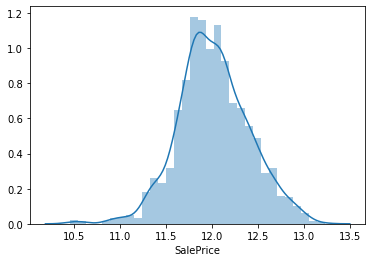

In [30]:
# --
# ■正規分布、SalesPrice

# 以下2同じ。対数取るだけ。
# ｜方法1
#目的変数の対数log(x+1)をとる
train_y = np.log1p(train_y)
#分布を可視化
# plt.figure(figsize=(20, 10))
# sns.distplot(train_y)

# ｜方法2
sns.distplot(np.log(train['SalePrice']))

# log
# 指定された double 値の自然対数値 (底は e) を返します。
# log1p
# 引数と 1 の合計の自然対数を返します。x の値が小さい場合、log1p(x) の結果は、log(1.0+x) の
# 浮動小数点評価よりも ln(1 + x) の真の結果にかなり近くなります。
# --


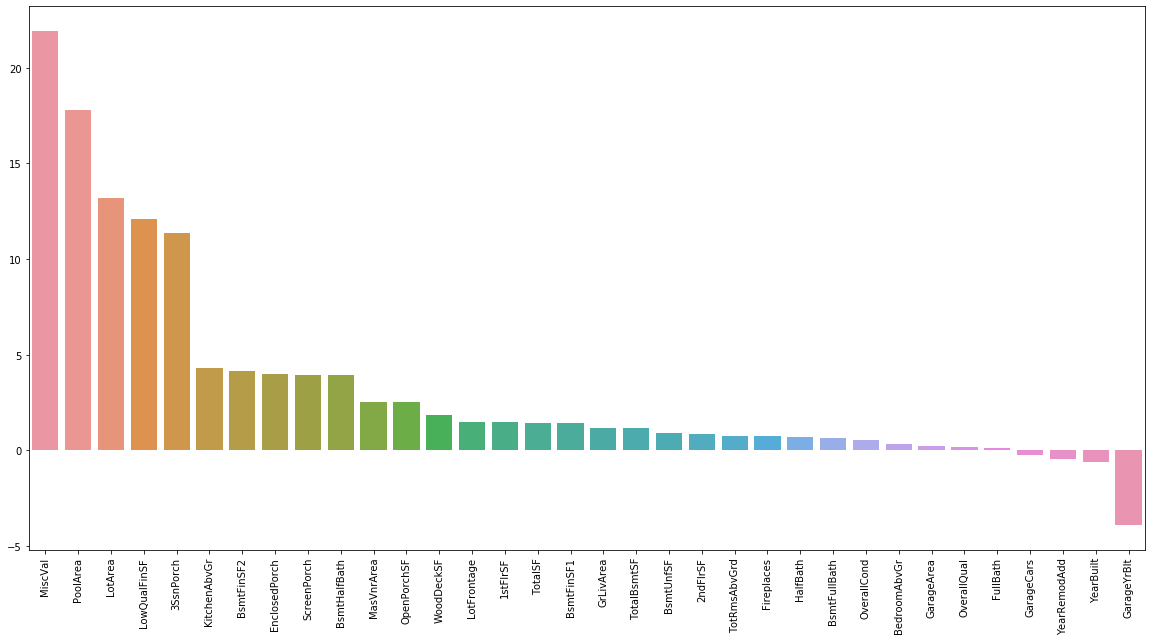

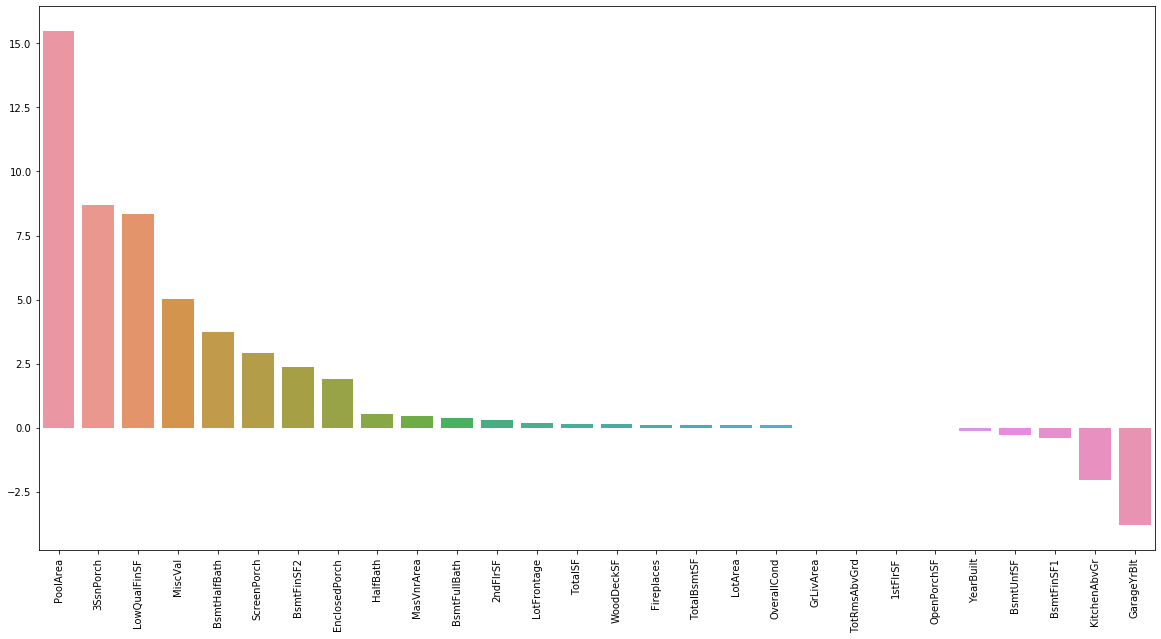

In [34]:
#数値の説明変数のリストを作成
num_feats = all_data.dtypes[all_data.dtypes != "object" ].index
# 目的変数
# ＝　予測したい変数
# 説明変数
# ＝　目的変数を説明する変数

#各説明変数の歪度を計算
skewed_feats = all_data[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)
# 歪度の閾値は0.5として、それよりも歪度が大きいものは対数変換することにします。

# # --
# # ■Box-Cox変換
# # ｜プラスのみ。
# #歪度の絶対値が0.5より大きい変数だけに絞る
# skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index

# #各変数の最小値を表示
# for i in skewed_feats_over:
#     print(min(all_data[i]))
# # --
# --
#■Yeo-Johnson変換
# ｜マイナスにも可能。
pt = PowerTransformer()
pt.fit(all_data[skewed_feats_over])

#変換後のデータで各列を置換
all_data[skewed_feats_over] = pt.transform(all_data[skewed_feats_over])

#各説明変数の歪度を計算
skewed_feats_fixed = all_data[skewed_feats_over].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)
# --


In [0]:
#特徴量に1部屋あたりの面積を追加
all_data["FeetPerRoom"] =  all_data["TotalSF"]/all_data["TotRmsAbvGrd"]

#その他有効そうなものを追加する

#建築した年とリフォームした年の合計
all_data['YearBuiltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

#バスルームの合計面積
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

#縁側の合計面積
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

#プールの有無
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#2階の有無
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#ガレージの有無
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#地下室の有無
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

#暖炉の有無
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [39]:
# カテゴリ変数は多くのモデルでそのまま分析に用いることができません。
# そのため、カテゴリ変数をエンコーディングしていきます。
#各カラムのデータ型を確認
all_data.dtypes.value_counts()

#カテゴリ変数となっているカラムを取り出す
cal_list = all_data.dtypes[all_data.dtypes=="object"].index.tolist()

#学習データにおけるカテゴリ変数のデータ数を確認
train_x[cal_list].info()

# 学習データの中に数が0となっているカテゴリ変数はないようですのでそのまま進めていきます。

# --
# one-hot-encoding
# 各カテゴリ変数を（0,1）の二値変数をそれぞれ作成します。これらの二値変数は「ダミー変数」と呼ばれます。
#カテゴリ変数をget_dummiesによるone-hot-encodingを行う
all_data = pd.get_dummies(all_data,columns=cal_list)

#サイズを確認
all_data.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 46 columns):
Alley            1451 non-null int64
BldgType         1451 non-null object
BsmtCond         1414 non-null object
BsmtExposure     1413 non-null object
BsmtFinType1     1414 non-null object
BsmtFinType2     1413 non-null object
BsmtQual         1414 non-null object
CentralAir       1451 non-null object
Condition1       1451 non-null object
Condition2       1451 non-null object
Electrical       1450 non-null object
ExterCond        1451 non-null object
ExterQual        1451 non-null object
Exterior1st      1451 non-null object
Exterior2nd      1451 non-null object
Fence            280 non-null object
FireplaceQu      761 non-null object
Foundation       1451 non-null object
Functional       1451 non-null object
GarageCond       1370 non-null object
GarageFinish     1370 non-null object
GarageQual       1370 non-null object
GarageType       1370 non-null object
Heating          1451 

(2910, 353)

train_x: (1451, 353)
test_x: (1459, 353)
[0]	eval-rmse:0.249135	train-rmse:0.249189
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 1000 rounds.
[1]	eval-rmse:0.246646	train-rmse:0.2467
[2]	eval-rmse:0.244181	train-rmse:0.244235
[3]	eval-rmse:0.241741	train-rmse:0.241795
[4]	eval-rmse:0.239326	train-rmse:0.23938
[5]	eval-rmse:0.236934	train-rmse:0.236988
[6]	eval-rmse:0.234567	train-rmse:0.234621
[7]	eval-rmse:0.232223	train-rmse:0.232277


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[8]	eval-rmse:0.229902	train-rmse:0.229956
[9]	eval-rmse:0.227605	train-rmse:0.227659
[10]	eval-rmse:0.225331	train-rmse:0.225385
[11]	eval-rmse:0.223079	train-rmse:0.223133
[12]	eval-rmse:0.22085	train-rmse:0.220904
[13]	eval-rmse:0.218643	train-rmse:0.218697
[14]	eval-rmse:0.216458	train-rmse:0.216512
[15]	eval-rmse:0.214295	train-rmse:0.214349
[16]	eval-rmse:0.212154	train-rmse:0.212208
[17]	eval-rmse:0.210034	train-rmse:0.210088
[18]	eval-rmse:0.207935	train-rmse:0.207989
[19]	eval-rmse:0.205857	train-rmse:0.205911
[20]	eval-rmse:0.2038	train-rmse:0.203854
[21]	eval-rmse:0.201764	train-rmse:0.201818
[22]	eval-rmse:0.199747	train-rmse:0.199802
[23]	eval-rmse:0.197751	train-rmse:0.197805
[24]	eval-rmse:0.195775	train-rmse:0.195829
[25]	eval-rmse:0.193819	train-rmse:0.193873
[26]	eval-rmse:0.191882	train-rmse:0.191936
[27]	eval-rmse:0.189965	train-rmse:0.190019
[28]	eval-rmse:0.188066	train-rmse:0.18812
[29]	eval-rmse:0.186187	train-rmse:0.186241
[30]	eval-rmse:0.184326	train-rmse:0.1

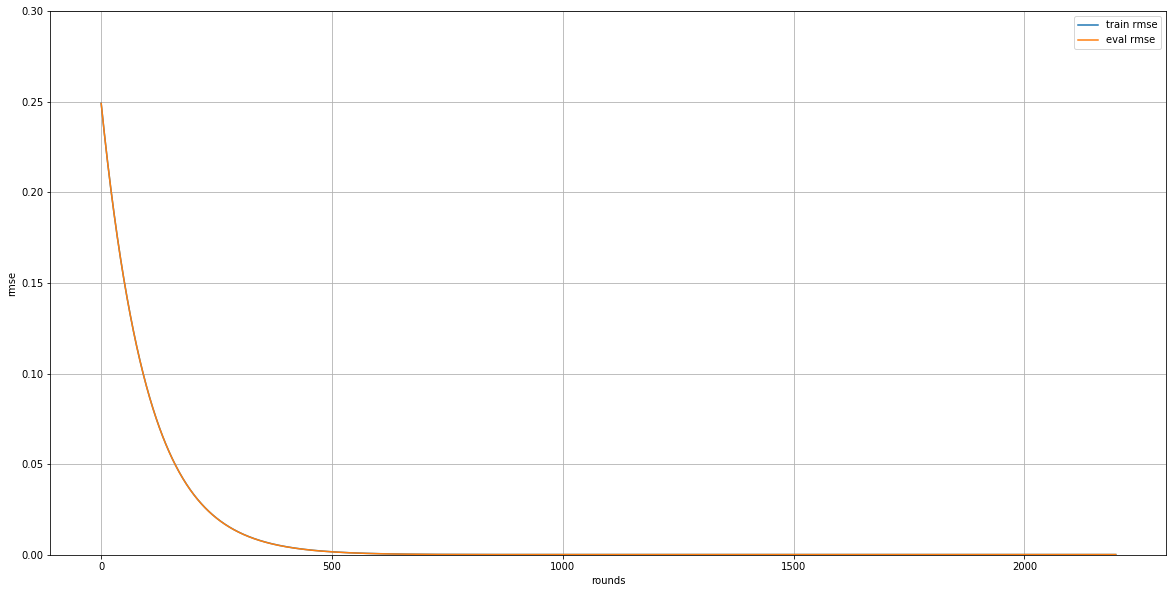

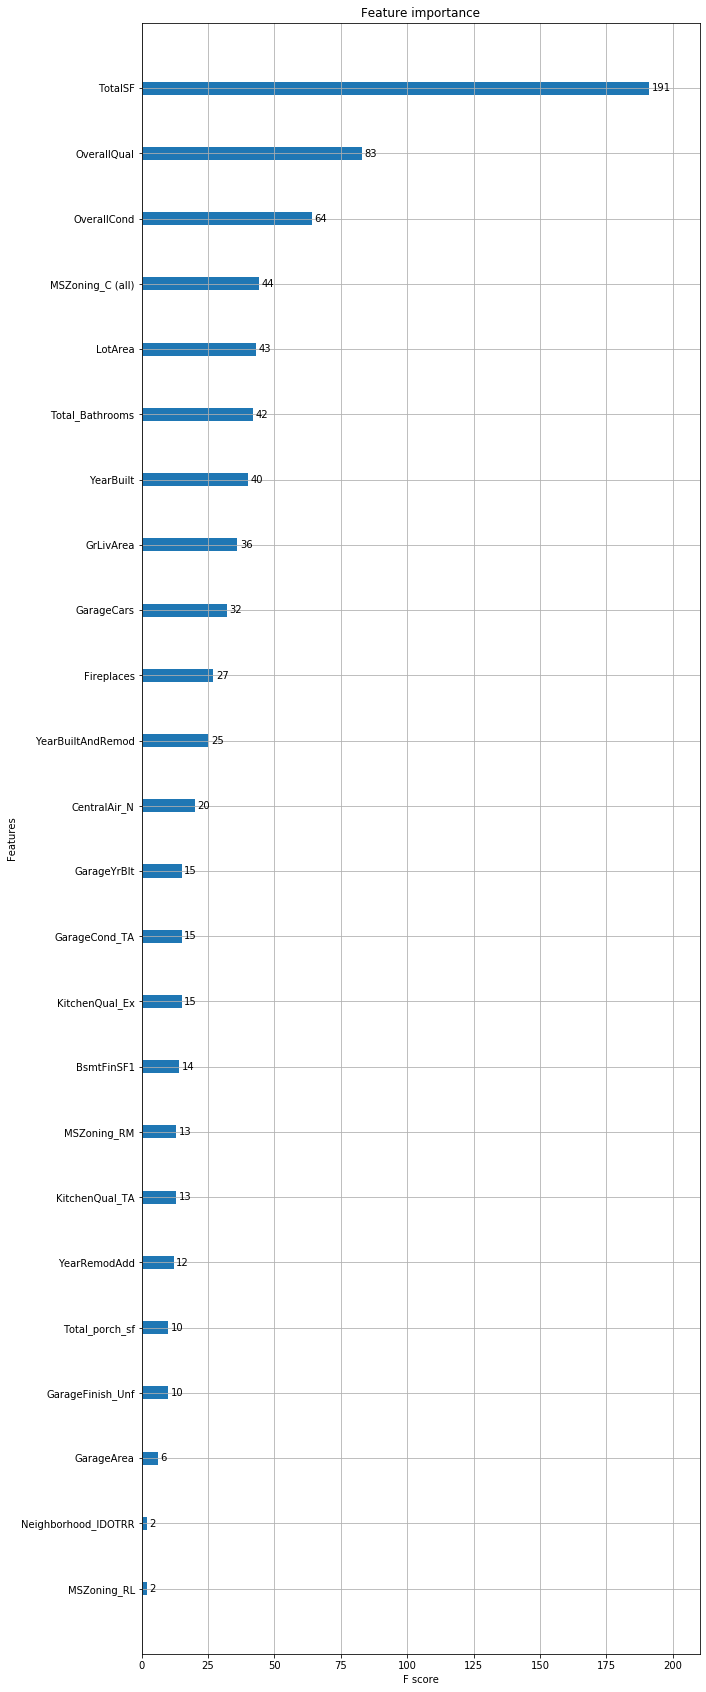

In [45]:
#学習データとテストデータに再分割
train_x = all_data.iloc[:train_x.shape[0],:].reset_index(drop=True)
test_x = all_data.iloc[train_x.shape[0]:,:].reset_index(drop=True)

#サイズを確認
print("train_x: "+str(train_x.shape))
print("test_x: "+str(test_x.shape))

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# データの分割
train_x, valid_x, train_y, valid_y = train_test_split(
        train_x,
        train_y,
        test_size=0.3,
        random_state=0)

# --
# ■GBDT（勾配ブースティング木）によるモデル作成
#特徴量と目的変数をxgboostのデータ構造に変換する
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x,label=valid_y)

#パラメータを指定してGBDT
num_round = 5000
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

evals_result = {}

#パラメータ
param = {
            'max_depth': 3,
            'eta': 0.01,
            'objective': 'reg:squarederror',
}

#学習の実行
bst = xgb.train(
  param, dtrain,
  num_round,
  evallist,
  evals_result=evals_result,
  # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
  early_stopping_rounds=1000
)
# 学習曲線を可視化する
plt.figure(figsize=(20, 10))
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.ylim(0, 0.3)
plt.show()

#特徴量ごとの重要度を可視化する
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(10, 30)

# あとはファイル作成